Monte Carlo integration result = 0.00000
Importance sampling integration result = 0.00000
True result = 0.00000
--------------------------------------------------------------------------------
Monte Carlo integration error = 0.00000
Importance sampling integration error = 0.00000


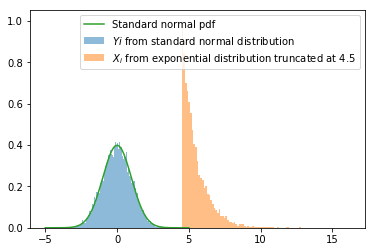

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon
from scipy.stats import norm

%matplotlib inline

def f_rvs(N):
    return norm.rvs(size=N)

def f(x):
    return norm.pdf(x)

def g_rvs(N, limit=4.5):
    return truncexpon.rvs(loc=limit, b=np.inf, size=N)

def g(x, limit=4.5):
    return truncexpon.pdf(x, loc=limit, b=np.inf)

def h(x, limit=4.5):
    return np.where(x > limit, 1.0, 0.0)

def I_1(rvs, limit=4.5):
    return np.mean(h(rvs, limit))

def I_2(rvs, limit=4.5):
    return np.mean(h(rvs, limit) * f(rvs) / g(rvs, limit))

N = 10000
cut_off = 4.5

norm_rvs = f_rvs(N)
result_1 = I_1(norm_rvs, cut_off)

expon_rvs = g_rvs(N, cut_off)
result_2 = I_2(expon_rvs, cut_off)

result_true = 1.0 - norm.cdf(cut_off)

print('Monte Carlo integration result = {:.5f}'.format(result_1))
print('Importance sampling integration result = {:.5f}'.format(result_2))
print('True result = {:.5f}'.format(result_true))
print(80 * '-')
print('Monte Carlo integration error = {:.5f}'.format(np.abs(result_1-result_true)))
print('Importance sampling integration error = {:.5f}'.format(np.abs(result_2-result_true)))

plt.hist(norm_rvs, bins=100, label='$Yi$ from standard normal distribution', alpha=0.5, density=True)
plt.hist(expon_rvs, bins=100, label='$X_i$ from exponential distribution truncated at {}'.format(cut_off),
         alpha=0.5, density=True)
plt.plot(np.linspace(-5,5,10000), norm.pdf(np.linspace(-5,5,10000)), label='Standard normal pdf')
plt.legend()
plt.show()

Running MCMC


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


Running MCMCMHLOG


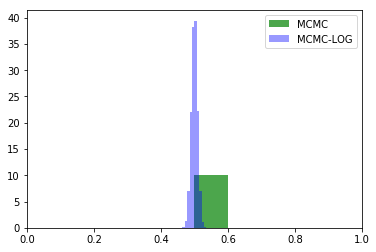

In [51]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt

# class defining the posterior distribution for the coin flip example
class target_coin_flip():
    def __init__(self, NN, NH):
        self.NN = NN # number of tosses
        self.NH = NH # number of heads
    def evaluate(self, H):
        # samples from the posterior
        pH=1 if (H>=0 and H<=1) else 0.0
        return np.power(H,self.NH)*np.power(1-H,self.NN-self.NH)*pH

#class defining the logarithmic representation of the posterior
class target_log_coin_flip():
    # TODO : use the "target_coin_flip" class as a starting point
    #        and edit appropriately to convert to logarithmic scale
    def __init__(self, num_tosses, num_heads):
        self.num_tosses = num_tosses
        self.num_heads = num_heads
        self.num_tails = num_tosses - num_heads
        
    def evaluate(self, H):
        # samples from the posterior
        if 0.0 <= H <= 1.0:
            return self.num_heads * np.log(H) + self.num_tails * np.log(1 - H)
        else:
            return 0
    
def MCMC(target, starting_sample, num_iters=1e6, burnin=1e4):
    print("Running MCMC")
    # Markov Chain Monte Carlo (MCMC) - Metropolis
    current_sample = starting_sample
    # proposal distribution is a Gaussian with mean 0.0 and std 0.1
    proposal_mean = 0.0
    proposal_sigma = 0.1
    samples = []
    samples.append(starting_sample)
    for iter_ in range(int(num_iters)):
        # GENERATION BASED ON PROPOSAL
        next_sample_candidate = current_sample + proposal_mean + np.random.randn()*proposal_sigma
        # ACCEPTANCE PROBABILITY - Metropolis
        acceptance_prob = np.min([1.0, target.evaluate(next_sample_candidate)/(target.evaluate(current_sample))])
        # ACCEPT OR REJECT with uniform probability
        temp = np.random.rand()
        if temp <= acceptance_prob:
            # ACCEPTING THE CANDIDATE SAMPLE
            samples.append(next_sample_candidate)
            current_sample = next_sample_candidate
        else:
            samples.append(current_sample)
    if len(samples)>burnin:
        # keep only samples after burn-in iterations
        samples=samples[int(burnin):]
    else:
        raise ValueError("Number of samples {:} smaller than burnin period {:}.".format(len(samples), burnin))
    return samples


def MCMCLOG(logtarget, starting_sample, num_iters=1e6, burnin=1e4):
    print("Running MCMCMHLOG")
    # Markov Chain Monte Carlo (MCMC) - Metropolis Hastings 
    # TODO: start from the "MCMC" function above and edit whenever
    #       necessary to convert to logarithmic scale
    current_sample = starting_sample
    # proposal distribution is a Gaussian with mean 0.0 and std 0.1
    proposal_mean = 0.0
    proposal_sigma = 0.1
    samples = [starting_sample]
    for _ in range(int(num_iters)):
        # GENERATION BASED ON PROPOSAL
        next_sample_candidate = current_sample + proposal_mean + np.random.randn()*proposal_sigma
        # ACCEPTANCE PROBABILITY - Metropolis
        acceptance_prob = np.min([0.0, logtarget.evaluate(next_sample_candidate) - logtarget.evaluate(current_sample)])
        # ACCEPT OR REJECT with uniform probability
        temp = np.log(np.random.rand())
        if temp <= acceptance_prob:
            # ACCEPTING THE CANDIDATE SAMPLE
            samples.append(next_sample_candidate)
            current_sample = next_sample_candidate
        else:
            samples.append(current_sample)
    if len(samples)>burnin:
        # keep only samples after burn-in iterations
        samples=samples[int(burnin):]
    else:
        raise ValueError("Number of samples {:} smaller than burnin period {:}.".format(len(samples), burnin))
    return samples

if __name__ == "__main__":

    #IN NN TOSSES, NH TIMES HEAD (NN>=NH)
    NN = 3000 # NN = 300 / 3000 tosses
    NH = 1500 # NH = 150 / 1500 heads
    burnin = 1e2 # number of burn-in iterations
    num_iters = 1e5 # number of total MCMC iterations
    starting_sample = 0.5 # starting point for MCMC algorithm
    
    target = target_coin_flip(NN,NH)
    samples_mcmc = MCMC(target, starting_sample, num_iters, burnin)
    # plot histogram with samples drawn from posterior distribution with the MCMC algorithm
    plt.hist(samples_mcmc, density=True, facecolor='g', alpha=0.7, bins=10, label="MCMC") # if you're using python>3, use density=True instead of normed=True
    plt.xlim([0,1])
    plt.legend()

    target = target_log_coin_flip(NN,NH)
    samples_mcmclog = MCMCLOG(target, starting_sample, num_iters, burnin)
    plt.hist(samples_mcmclog, density=True, facecolor='b', alpha=0.4, bins=10, label="MCMC-LOG")
    plt.xlim([0,1])
    plt.legend()
    plt.show()